# CS101-3: Variational Quantum Eigensolver

This notebook walks you through the steps necessary to find the energy surface of the hydrogen molecule as a function of the bond length.

In [ ]:
# PyQuil libraries
from pyquil import Program, get_qc
from pyquil.gates import *
from pyquil.noise import estimate_bitstring_probs
from pyquil.quil import DefGate

# Python libraries
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

# coefficients required for the Hamiltonian
data = np.genfromtxt('vqe.dat', skip_header=1, dtype=None,delimiter=' ')

In [4]:
# Preparing the ansatz that we used in Lecture 11, Section 4
def ansatz(theta):
    p = Program()
    
    # apply the following sequence of gates
    p += X(1)
    p += H(0)
    p += RX(-np.pi/2, 1)
    p += CNOT(0, 1)
    p += RZ(theta[0], 1)
    p += CNOT(0, 1)
    p += H(0)
    p += RX(np.pi/2, 1)

    return p

Optimization terminated successfully.
         Current function value: 0.135375
         Iterations: 2
         Function evaluations: 45
Optimization terminated successfully.
         Current function value: -0.615245
         Iterations: 5
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: -0.931060
         Iterations: 2
         Function evaluations: 77
Optimization terminated successfully.
         Current function value: -1.065809
         Iterations: 3
         Function evaluations: 52
Optimization terminated successfully.
         Current function value: -1.133990
         Iterations: 4
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: -1.155345
         Iterations: 5
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -1.146808
         Iterations: 4
         Function evaluations: 82
Optimization terminated successful

<Figure size 432x288 with 0 Axes>

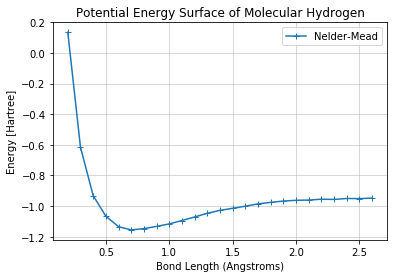

<Figure size 432x288 with 0 Axes>

In [5]:
# Calculating the expected energy of the Hydrogen Molecule
energy_surface = []

# loop over different bond lengths
for i in range(0,25):
    coeff = data[i,1:]
    
    # Construct the objective function for minimizing the potential energy
    # surface of molecular hydrogen
    def obj(x):
        
        # Identity (no measurement needed)
        energy = coeff[0]
        
        # Measure ZI
        p = ansatz(x)
        p.wrap_in_numshots_loop(1000)
        ro = p.declare('ro', 'BIT', 2)
        p += MEASURE(0, ro[0])
        p += MEASURE(1, ro[1])
        qc = get_qc('2q-qvm')
        exe = qc.compile(p)
        result = qc.run(exe)
        probs = estimate_bitstring_probs(result)
        energy += coeff[1] * (probs[0,0] + probs[0,1] - probs[1,0] - probs[1,1])
        
        # Measure IZ
        p = ansatz(x)
        p.wrap_in_numshots_loop(1000)
        ro = p.declare('ro', 'BIT', 2)
        p += MEASURE(0, ro[0])
        p += MEASURE(1, ro[1])
        qc = get_qc('2q-qvm')
        exe = qc.compile(p)
        result = qc.run(exe)
        probs = estimate_bitstring_probs(result)
        energy += coeff[2] * (probs[0,0] + probs[1,0] - probs[0,1] - probs[1,1])
        
        # Measure ZZ
        p = ansatz(x)
        p.wrap_in_numshots_loop(1000)
        ro = p.declare('ro', 'BIT', 2)
        p += MEASURE(0, ro[0])
        p += MEASURE(1, ro[1])
        qc = get_qc('2q-qvm')
        exe = qc.compile(p)
        result = qc.run(exe)
        probs = estimate_bitstring_probs(result)
        energy += coeff[3] * (probs[0,0] - probs[0,1] - probs[1,0] + probs[1,1])
        
        # Measure XX
        p = ansatz(x)
        p.wrap_in_numshots_loop(1000)
        ro = p.declare('ro', 'BIT', 2)
        p += H(0)
        p += H(1)
        p += MEASURE(0, ro[0])
        p += MEASURE(1, ro[1])
        qc = get_qc('2q-qvm')
        exe = qc.compile(p)
        result = qc.run(exe)
        probs = estimate_bitstring_probs(result)
        energy += coeff[4] * (probs[0,0] - probs[0,1] - probs[1,0] + probs[1,1])
        
        # Measure YY
        p = ansatz(x)
        p.wrap_in_numshots_loop(1000)
        ro = p.declare('ro', 'BIT', 2)
        p += RX(-np.pi/2, 0)
        p += RX(-np.pi/2, 1)
        p += MEASURE(0, ro[0])
        p += MEASURE(1, ro[1])
        qc = get_qc('2q-qvm')
        exe = qc.compile(p)
        result = qc.run(exe)
        probs = estimate_bitstring_probs(result)
        energy += coeff[5] * (probs[0,0] - probs[0,1] - probs[1,0] + probs[1,1])
        
        return energy
    
    # In order to minimize the objective function we use the Powell optimization method
    res = minimize(obj,
                   x0=[0],
                   method='Powell', # or Nelder-Mead
                   options={'maxiter': 100, 'disp': True})
    energy_surface.append(res.fun)


# Plot
%matplotlib inline  
plt.figure()
plt.plot(data[0:25,0], energy_surface, '-+')
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Potential Energy Surface of Molecular Hydrogen")
plt.xlabel("Bond Length (Angstroms)")
plt.ylabel("Energy [Hartree]")
plt.figure()